# Third-party software computation model example

## Introduction

This example file demonstrates how to build a RunModel object which enables UQpy to execute models in third-party software. The files necessary to run this example are:
1. The input template - 'abaqus_input.py'
2. The model script - 'abaqus_fire_analysis.py'
3. The output script - 'extract_abaqus_output.py'
4. The script used by the output script - 'abaqus_output_script.py'

Note: To execute the example in this notebook, it is necessary to have access to the finite element solver Abaqus. 

## Description of the model

This example builds and analyzes a finite element model of a beam bearing uniformly distributed load, which is then subjected to fire load.  

## The script:

Import the python modules used in this example, note down the start time and the current directory, which will be used later to save the results.

In [1]:
from UQpy.RunModel import *
from UQpy.SampleMethods import STS
from UQpy.Distributions import Normal, Uniform
import time
import os
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np

calling_directory = os.getcwd()
t = time.time()

### Building the model:

There are two probabilistic input variables, the fire load density and the yield strength. The fire load density is denoted as 'qtd' and the yield strength is denoted as 'fy' in the template input script. These are different from the default variable names used by RunModel, and hence they must be passed in as one of the inputs while building the RunModel object.

In [2]:
var_names = ['qtd', 'fy']

#### Create the model object

In [3]:
abaqus_sfe_model = RunModel(model_script='abaqus_fire_analysis.py', input_template='abaqus_input.py',
                            output_script='extract_abaqus_output.py',
                            var_names=var_names, ntasks=1, model_dir='SFE_Example')
print('Example: Created the model object.')

Example: Created the model object.


### Specifying the distributions

The fire load density is assumed to be uniformly distributed between 50 MJ/m^2 and 450 MJ/m^2. The yield strength is assumed to be normally distributed, with the parameters being: mean = 250 MPa and coefficient of variation of 7%.

In [4]:
dist1 = Uniform(loc=50, scale=400)
dist2 = Normal(loc=250e6, scale=17.5e6)
dists = [dist1, dist2]

### Building the stratified sampling (STS) object

In [5]:
x_sts = STS(dist_object=dists) 

### Generating samples using STS

In [6]:
x_sts.run(sts_design=[3, 3], random_state=np.random.RandomState(1234567890))
print('Example: Created STS samples. They are:')
print(x_sts.samples)

Example: Created STS samples. They are:
[[1.3250597e+02 2.3392594e+08]
 [2.6221646e+02 2.3058856e+08]
 [4.3515784e+02 2.3736432e+08]
 [1.6888730e+02 2.4861218e+08]
 [2.4434233e+02 2.5674296e+08]
 [4.2042508e+02 2.4295275e+08]
 [8.5608505e+01 2.5978707e+08]
 [3.1614749e+02 2.5889262e+08]
 [3.8867932e+02 2.6522442e+08]]


### Executing the model with inputs from STS

In [7]:
# Running simulations using the previously defined model object and samples
sample_points = x_sts.samples
abaqus_sfe_model.run(samples=sample_points)

Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.


### Saving the STS results to a pickle file

In [8]:
# The output from each analysis is the difference between the maximum allowable displacement and the 
# maximum displacement of the midpoint of the beam.
qois = abaqus_sfe_model.qoi_list

# Save the samples and the qois in a dictionary called results with keys 'inputs' and 'outputs'
results = {'inputs': sample_points, 'outputs': qois}

# Pickle the results dictionary in the current directory. The basename and extension of the desired pickle file:
res_basename = 'STS_results'
res_extension = '.pkl'

# Create a new results file with a larger index than any existing results files with the same name in the current
# directory.
res_file_list = glob.glob(res_basename + '_???' + res_extension)
if len(res_file_list) == 0:
    res_file_name = res_basename + '_000' + res_extension
else:
    max_number = max(res_file_list).split('.')[0].split('_')[-1]
    res_file_name = res_basename + '_%03d' % (int(max_number) + 1) + res_extension

res_file_name_sts = os.path.join(calling_directory, res_file_name)
# Save the results to this new file.
with open(res_file_name_sts, 'wb') as f:
    pickle.dump(results, f)
print('Saved the results to ' + res_file_name)

Saved the results to STS_results_000.pkl


### Plotting the results and saving the plot

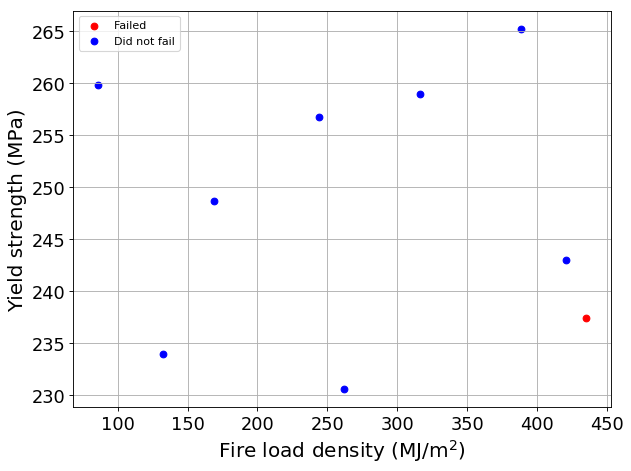

Probability of failure using 9 samples:  0.111111


In [9]:
# Load the results from the latest pickle dump.
with open(res_file_name, 'rb') as f:
    results = pickle.load(f)

# Use the values loaded from pickle file.
sample_points = results['inputs']
Y = np.array(results['outputs'])

x = sample_points[:, 0]
y = sample_points[:, 1]

# 2D plot showing success or failure
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p3 = plt.scatter(x[Y < 0], y[Y < 0] * 1e-6, color='Red', label='Failed')
p4 = plt.scatter(x[Y >= 0], y[Y >= 0] * 1e-6, color='Blue', label='Did not fail')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Fire load density (MJ/m$^2$)', FontSize=18)
plt.ylabel('Yield strength (MPa)', FontSize=18)
plt.legend()
plt.tight_layout()
plt.savefig('FireExampleSTS.pdf')
plt.show()
    
# Compute probability of failure
probability_of_failure = len(Y[Y < 0])/len(Y)
print('Probability of failure using %d samples: % 0.6f' % (len(Y), probability_of_failure))

In [10]:
print('Example: Done!')
print('Time elapsed: %.2f minutes' % float((time.time() - t) / 60.0))

Example: Done!
Time elapsed: 5.20 minutes


### Plotting results with 1024 samples

This plot generates Figure 5(b) in the paper. The figure shows the results of propagating 1024 samples, drawn using STS with seed=1234567890, through the model. These results are loaded from the pickle file 'STS_results_1024_samples.pkl', provided along with this Notebook.

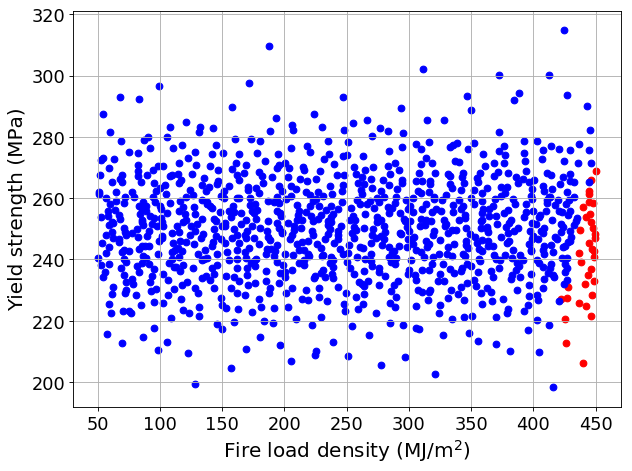

Probability of failure using 1024 samples:  0.033203


In [11]:
res_file_name = 'STS_results_1024_samples.pkl'
# Load the results from the latest pickle dump.
with open(res_file_name, 'rb') as f:
    results = pickle.load(f)

# Use the values loaded from pickle file.
sample_points = results['inputs']
Y = np.array(results['outputs'])

x = sample_points[:, 0]
y = sample_points[:, 1]

# 2D plot showing success or failure
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(111)
p3 = plt.scatter(x[Y < 0], y[Y < 0] * 1e-6, color='Red', label='Failed')
p4 = plt.scatter(x[Y >= 0], y[Y >= 0] * 1e-6, color='Blue', label='Did not fail')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Fire load density (MJ/m$^2$)', FontSize=18)
plt.ylabel('Yield strength (MPa)', FontSize=18)
# plt.legend()
plt.tight_layout()
plt.savefig('FireExampleSTS_1024_samples.pdf')
plt.show()
    
# Compute probability of failure
probability_of_failure = len(Y[Y < 0])/len(Y)
print('Probability of failure using %d samples: % 0.6f' % (len(Y), probability_of_failure))